# Advertisement images data exploration & final system quality management

## EDA

In [34]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

Let's look at some example images:

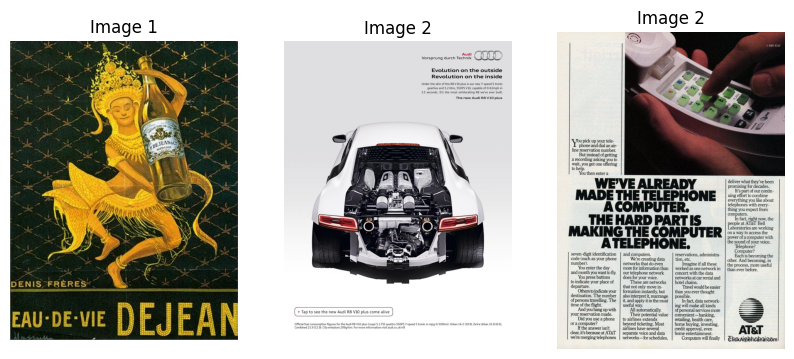

In [35]:
def read_image(image_path):
    img = Image.open(image_path)
    return img

img1 = read_image("./1/165071.jpg")
img2 = read_image("./1/1651.jpg")
img3 = read_image("./0/350.jpg")
# Display images in one row
fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Creating a figure with two subplots in one row

axes[0].imshow(img1)  # Display first image in the first subplot
axes[0].axis('off')   # Turn off axis
axes[0].set_title('Image 1')  # Set title

axes[1].imshow(img2)  # Display second image in the second subplot
axes[1].axis('off')   # Turn off axis
axes[1].set_title('Image 2')  # Set title

axes[2].imshow(img3)  # Display second image in the second subplot
axes[2].axis('off')   # Turn off axis
axes[2].set_title('Image 2')  # Set title

plt.show()  # Show the plotb

For every image of dataset we hava annotations. Usually annotations are in this 39 classes, but there were no strict validation for this dataset, so annotations can include undeclared labels. Let's examine this labels:

In [36]:
import re

lines = []
with open("./annotations_images/image/Topics_List.txt", "r", encoding='utf-16') as file:
    for line in file:
        match = re.match(r'^(\d+)\s+(.+)$', line)
        if match:
            line_number = int(match.group(1))
            line_text = match.group(2)
            lines.append((line_number, line_text))
            
topics_df = pd.DataFrame(lines)

In [37]:
lines[:5]

[(1, '"Restaurants, cafe, fast food" (ABBREVIATION: "restaurant")'),
 (2, '"Chocolate, cookies, candy, ice cream" (ABBREVIATION: "chocolate")'),
 (3,
  '"Chips, snacks, nuts, fruit, gum, cereal, yogurt, soups" (ABBREVIATION: "chips")'),
 (4, '"Seasoning, condiments, ketchup" (ABBREVIATION: "seasoning")'),
 (5, '"Pet food" (ABBREVIATION: "petfood")')]

In [38]:
import json 
with open("./annotations_images/image/Topics.json", "r") as file:
    annotations_dict = json.load(file)
filtered_dict = {key: value for key, value in annotations_dict.items() if key.startswith('0/') or key.startswith('1/')}

# Transform the remaining dictionary into a pandas DataFrame
data = {key: [str(item) for item in value] for key, value in filtered_dict.items()}
annotations_df = pd.DataFrame(data.keys(), columns=['image_path'])
annotations_df['labels'] = annotations_df['image_path'].map(data)
labels = annotations_df.explode('labels').reset_index(drop=True)

While assessors had a clear instruction to use labels mentioned, some of the men are very creative and rarely can use different labels:

In [39]:
labels['labels'].value_counts()[39:]

labels
Tobacco                       25
groceries                     20
Groceries                     18
cigarettes                    12
insurance                     11
                              ..
bar/nightclub                  1
Invitian to a beach party.     1
bar/nightclub                  1
event, clubs, bar, alcohol     1
Half marathon                  1
Name: count, Length: 570, dtype: int64

Let's get rid of this misleading categories and assemble our image-to-label DataFrame.

In [40]:
clear_topics = labels['labels'].value_counts()[:39].index.values
labels['weight'] = 1
targets = pd.pivot_table(labels[labels["labels"].isin(clear_topics)], columns="labels", index="image_path", values='weight')
topics_dict = topics_df.set_index(0).to_dict()[1]
targets.columns = [topics_dict[int(col)] for col in targets.columns]
targets.fillna(0, inplace=True)

Here we have dataset with attribution to the topics we are interested in:

In [23]:
targets.sum(axis=0)

"Restaurants, cafe, fast food" (ABBREVIATION: "restaurant")                                                                                  716.0
"Electronics (computers, laptops, tablets, cellphones, TVs, etc.)" (ABBREVIATION: "electronics")                                            1008.0
"Phone, TV and internet service providers" (ABBREVIATION: "phone_tv_internet_providers")                                                     304.0
"Financial services (banks, credit cards, investment firms, etc.)" (ABBREVIATION: "financial")                                               371.0
"Education (universities, colleges, kindergarten, online degrees, etc.)" (ABBREVIATION: "education")                                          74.0
"Security and safety services (anti-theft, safety courses, etc.)" (ABBREVIATION: "security")                                                  36.0
"Software (internet radio, streaming, job search website, grammar correction, travel planning, etc.)" (ABBREVIATION: "

For ease let's state following assumptions:
0. Labels are associated to Ad (image and text on it), not image. Example: The Ad can be not that straight forward and show Car, but not advertise car, but treat car as symbol of success and advertise investment/smoking/any other stuff.
1. Image is relevant to the topic if at least one assessor decided that it's relevant
2. Topic is relevant to every image which is labeled with this topic
3. Labeling is not ideal, but it's the best we have
4. We are not focused on specific topic, so all topics are equal in terms of weights

## Measuring search engine quality

Let's for every topic collect best matching results and examine the level of it's relevance: 

In [24]:
from qdrant_client import QdrantClient
from transformers import CLIPModel, CLIPProcessor

model_name = "openai/clip-vit-base-patch32"
qdrant_host: str = "localhost"
qdrant_port: int = 6333
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)
# model = torch.compile(model)
db_client = QdrantClient(url=f"http://{qdrant_host}:{qdrant_port}")
collection_name = "DEFAULT_COLLECTION"

In [25]:
results = []
for col in targets.columns:
    query = col
    processed_input = processor(text=query, return_tensors="pt")
    query = model.get_text_features(**processed_input)
    query = query.detach().tolist()[0]
    res = db_client.search(
                collection_name=collection_name,
                query_vector=query,
                with_payload=True,
            )
    results.append(res)

In [26]:
 outputs = [[value.payload['path'].split("data/")[1] for value in list_] for list_ in results ]

"Restaurants, cafe, fast food" (ABBREVIATION: "restaurant")
Relevances of images acording to markup: [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


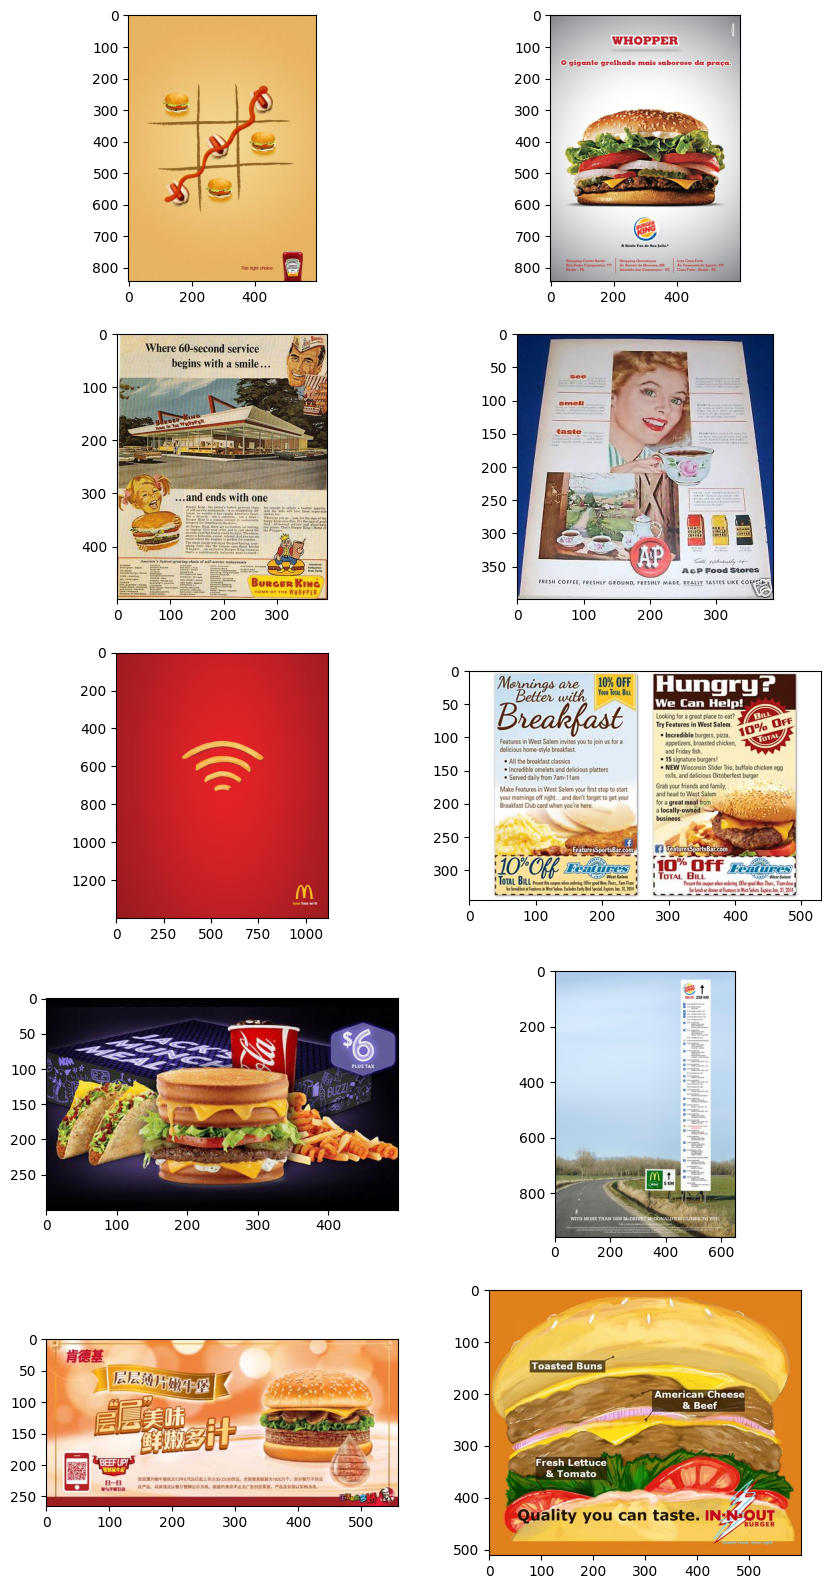

In [27]:
query, query_resp = list(zip(targets.columns, outputs))[0]

fig, axes = plt.subplots(5, 2, figsize=(10, 20))  # Creating a figure with two subplots in one row

print(query)
relevance_list = []
for idx, item in enumerate(query_resp):
    res = targets.loc[item][query]
    img = read_image(item)
    axes[idx//2, idx % 2].imshow(img)  # Display first image in the first subplot    
    relevance_list.append(res)
print("Relevances of images acording to markup:", relevance_list)
# [all relevant]
# [2, 6, 8 has wrong markup]
# [3, 4, 5 has wrong markup, 8]
# [1, 3, 6 add of banking equipment, 9 wrong markup]
# [0, 4, 6 add of PC, 7 add of software company]bb

Dataset log's show, that our images 0 and 3 are irrelevant, while image 0 is an ad of popular MacDonald's restaurants and 3 image is a ride-through menu of some other eatery. For other topic other problems can be found. For example let's look at topic 4, Coffee, tea:

"Coffee, tea" (ABBREVIATION: "coffee")
Relevances of images according to markup: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


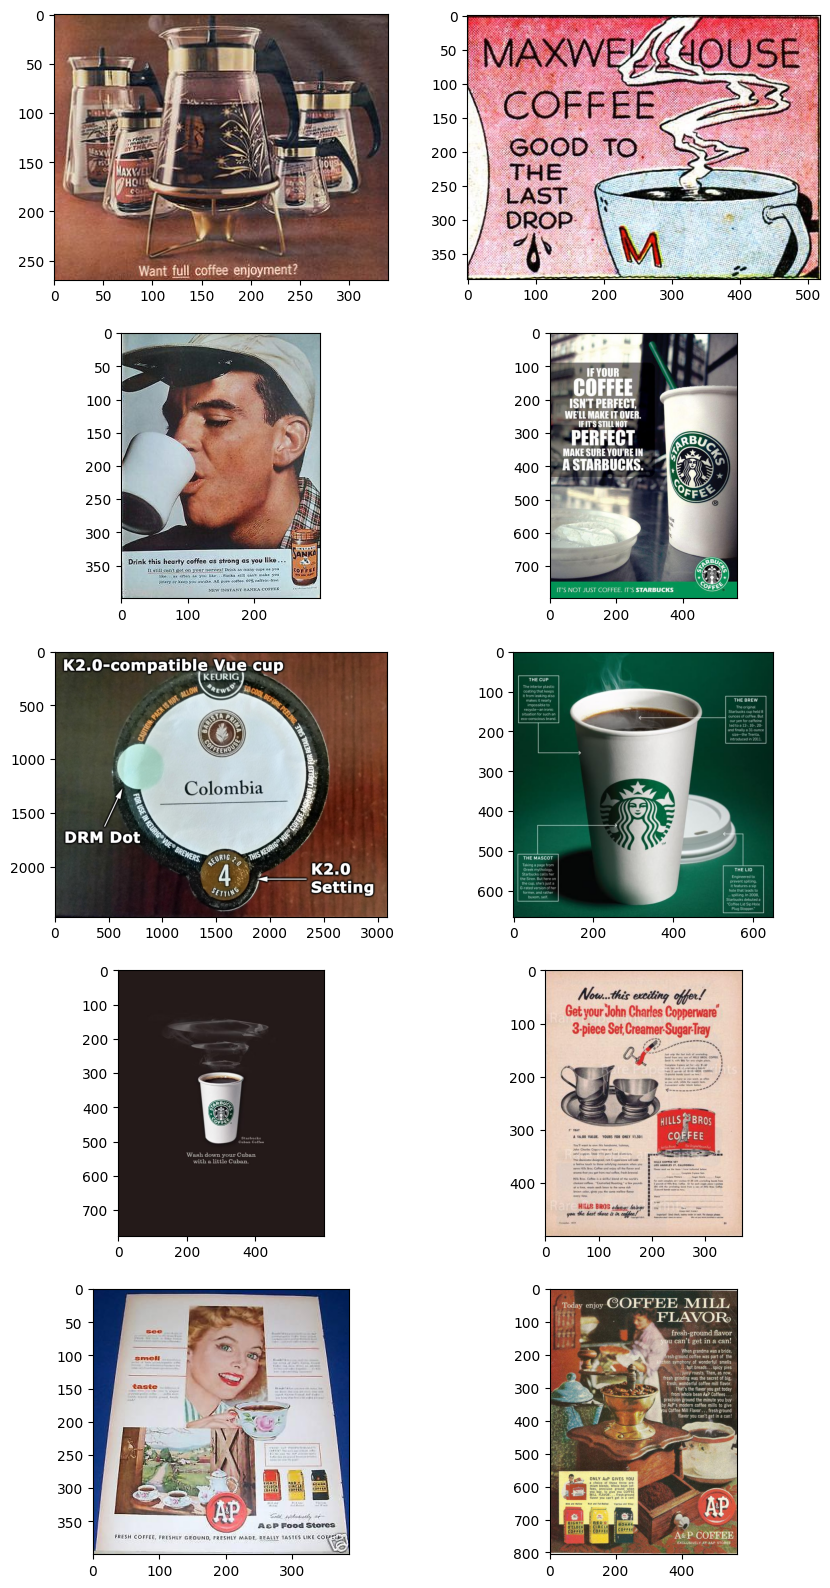

In [52]:
query, query_resp = list(zip(targets.columns, outputs))[36]

fig, axes = plt.subplots(5, 2, figsize=(10, 20))  # Creating a figure with two subplots in one row

print(query)
relevance_list = []
for idx, item in enumerate(query_resp):
    res = targets.loc[item][query]
    img = read_image(item)
    axes[idx//2, idx % 2].imshow(img)    
    relevance_list.append(res)
print("Relevances of images according to markup:", relevance_list)

Looks perfect both for me and dataset markup!

### Method of retrieval system quality measurement

In [28]:
from sympy import symbols, Sum, Eq

# Define variables
n = symbols('n')
precision_at_n = symbols('P@n')
mean_average_precision = symbols('MAP')

# Define left and right sides of the equation
left_side = mean_average_precision
right_side = (1/n) * Sum(precision_at_n, (n, 1, n))

# Define equation
map_equation = Eq(left_side, right_side)

In [29]:
# Define variables
precision_at_n = symbols('P@n')
true_positives = symbols('TP@n')
false_positives = symbols('FP@n')

# Define left and right sides of the equation
left_side_precision = precision_at_n
right_side_precision = true_positives / (true_positives + false_positives)

# Define precision equation
precision_equation = Eq(left_side_precision, right_side_precision)


Qdrant is an ANN vector search base with fixed output and frontend of my app has limited space. Usually ranking is a second stage for best results. So it's relevant to use mAP metric as a measure of quality. 

In [30]:
map_equation

Eq(MAP, Sum(P@n, (n, 1, n))/n)

In [31]:
precision_equation

Eq(P@n, TP@n/(FP@n + TP@n))

We have gathered all the needed data, so let's calculate the final metric:

In [32]:
dataset_markup = []
estimated_relevance = []
for query, query_resp in zip(targets.columns, outputs):
    estimated_relevance.append(list())
    dataset_markup.append(list())
    for item in query_resp:
        res = targets.loc[item][query]
        img = read_image(item)
        estimated_relevance[-1].append(1)
        dataset_markup[-1].append(res)

In [33]:
import numpy as np

def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [59]:
mapk(dataset_markup, estimated_relevance)

0.09743589743589745